/tmp/ipykernel_1499926/3906954755.py:51: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1499926/3906954755.py:51: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1499926/3906954755.py:51: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1499926/3906954755.py:51: UserWarning: Glyph 31186 (\N{CJK UNIFIED IDEOGRAPH-79D2}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1499926/3906954755.py:51: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1499926/3906954755.py:51: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1499926/3906954755.py:51: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  

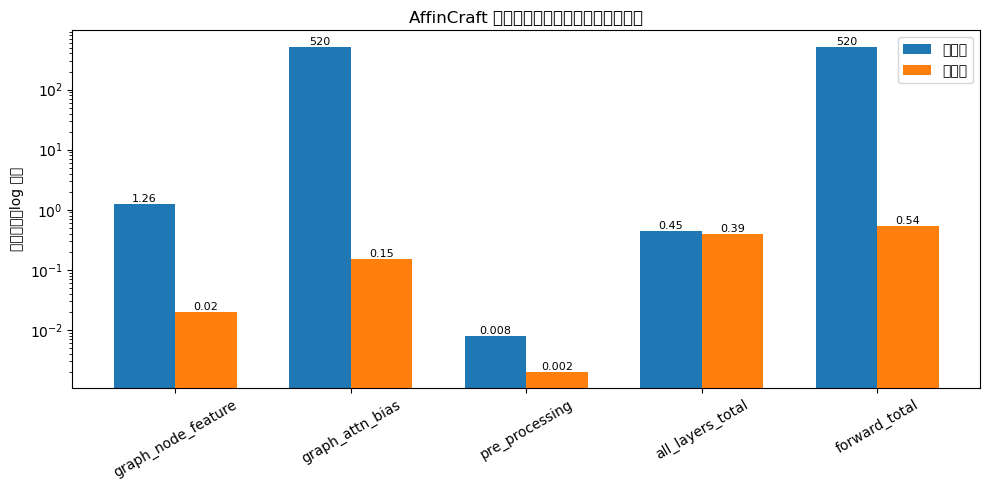

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# ==== 你可以根据自己理解微调这些估算值 ====

# 单位：秒（s）
before = {
    "graph_node_feature": 1.26,   # 按 8 次日志平均
    "graph_attn_bias":   520.0,   # 粗略取中间值
    "pre_processing":    0.008,   # 你日志中大约 0.007~0.01s
    "all_layers_total":  0.45,    # all layers total ~ 0.35~0.55s
    "forward_total":     520.0    # 取中位数近似
}

after = {
    "graph_node_feature": 0.020,  # 按 8 次日志平均
    "graph_attn_bias":   0.150,   # 按多次日志平均
    "pre_processing":    0.002,   # 日志中 0.001~0.002s
    "all_layers_total":  0.39,    # 日志中 0.38~0.41s
    "forward_total":     0.54     # 按 4 次平均
}

modules = list(before.keys())
before_vals = [before[m] for m in modules]
after_vals  = [after[m]  for m in modules]

x = np.arange(len(modules))
width = 0.35

plt.figure(figsize=(10, 5))

# 用对数坐标更清楚，差异太大
plt.bar(x - width/2, before_vals, width, label='加速前')
plt.bar(x + width/2, after_vals,  width, label='加速后')

plt.yscale('log')
plt.xticks(x, modules, rotation=30)
plt.ylabel("时间（秒，log 轴）")
plt.title("AffinCraft 各模块加速前后耗时对比（示意）")
plt.legend()

# 在柱子上标注数值（可选）
def autolabel(values, xpos):
    for i, v in enumerate(values):
        plt.text(xpos[i], v, f"{v:.3g}",
                 ha='center', va='bottom', fontsize=8)

autolabel(before_vals, x - width/2)
autolabel(after_vals,  x + width/2)

plt.tight_layout()
plt.show()

Epoch  TrainLoss  ValidLoss
    1  0.375915   0.285481 
    2  0.208783   0.126601 
    3  0.09672    0.06684  
    4  0.057189   0.044533 
    5  0.041902   0.035056 
    6  0.029517   0.027386 
    7  0.022007   0.02048  
    8  0.017917   0.015289 
    9  0.01456    0.013882 


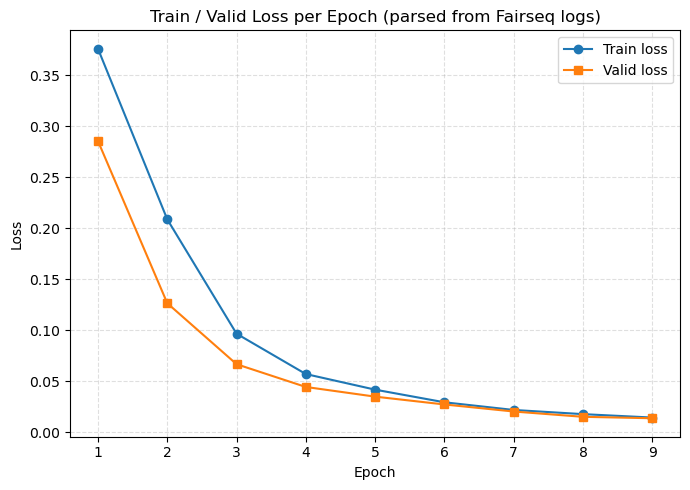

In [2]:
import re
import matplotlib.pyplot as plt

log_file = "/xcfhome/zncao02/affincraft-nn/scripts/train_loss.txt"

# 正则：捕获 epoch 编号和 loss
# 1) 训练 epoch summary 行（end of epoch 后那行）
#    例如：
#    2025-11-20 07:04:20 | INFO | train | epoch 006 | loss 0.029517 | ...
train_epoch_pattern = re.compile(
    r"train \|\s*epoch\s+(\d+)\s*\|\s*loss\s+([0-9.]+)"
)

# 2) valid 行：
#    例如：
#    2025-11-20 07:03:43 | INFO | valid | epoch 006 | valid on 'valid' subset | loss 0.027386 | ...
valid_epoch_pattern = re.compile(
    r"valid \|\s*epoch\s+(\d+)\s*\|.*?\|\s*loss\s+([0-9.]+)"
)

train_losses = {}
valid_losses = {}

with open(log_file, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()

        # 匹配 train summary
        m_train = train_epoch_pattern.search(line)
        if m_train:
            epoch = int(m_train.group(1))
            loss = float(m_train.group(2))
            train_losses[epoch] = loss
            continue

        # 匹配 valid
        m_valid = valid_epoch_pattern.search(line)
        if m_valid:
            epoch = int(m_valid.group(1))
            loss = float(m_valid.group(2))
            valid_losses[epoch] = loss
            continue

# 对 epoch 排序，构造曲线数据
epochs = sorted(set(train_losses.keys()) | set(valid_losses.keys()))

train_y = [train_losses.get(e, None) for e in epochs]
valid_y = [valid_losses.get(e, None) for e in epochs]

print("Epoch  TrainLoss  ValidLoss")
for e, t, v in zip(epochs, train_y, valid_y):
    print(f"{e:5d}  {t!s:9}  {v!s:9}")

# 画图
plt.figure(figsize=(7, 5))

if any(v is not None for v in train_y):
    plt.plot(epochs, train_y, marker="o", label="Train loss")

if any(v is not None for v in valid_y):
    plt.plot(epochs, valid_y, marker="s", label="Valid loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train / Valid Loss per Epoch (parsed from Fairseq logs)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=200)
plt.show()